# September 14, 2022: ISC matrices: MAX trial level responses: Early vs Late: Mashid ROIs

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import (norm, zscore, permutation_test)
from itertools import combinations

# ISC
from brainiak.isc import (
    isc, isfc, bootstrap_isc, compute_summary_statistic, squareform_isfc, compute_correlation,
    _check_timeseries_input, _check_targets_input, _threshold_nans
)
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import squareform

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/sep22"

# folders
sys.path.insert(0, proj_dir)
# import helpers.dataset_utils as dataset_utils
import helpers.isc_utils as isc_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.LABELS = [0, 1]
args.NAMES = ['safe', 'threat']
args.MASK = -100

set_name = 'mashid'

args.SEED = 74
np.random.seed(args.SEED)

# ROIs
roi_set_file = f"{proj_dir}/data/rois/{set_name}/roi_set_{set_name}.csv"
args.roi_set_df = pd.read_csv(roi_set_file)
args.roi_set_df = args.roi_set_df.sort_values(by=['network'])
display(args.roi_set_df)

args.roi_names = args.roi_set_df['roi_name'].values
args.nw_names = args.roi_set_df['network'].values
args.roi_idxs = args.roi_set_df.index.values
args.num_rois = len(args.roi_idxs)

# trial level responses
with open(f"{proj_dir}/data/max/desc-exploratory_data_trial_level_responses_rois-{set_name}.pkl", 'rb') as f:
    X = pickle.load(f)

# change roi ordering
for label in args.LABELS:
    for idx_subj in range(len(X[label])):
        X[label][idx_subj] = X[label][idx_subj][:, :, args.roi_idxs]

,network,mashid_roi_name,coordinates,roi_name,in_MAX
22,Executive,Lateral parietal R,"[38, -56, 44]",R lat. PC,False
24,Executive,Inferior temporal R,"[58, -54, -16]",R ITG,False
23,Executive,Lateral parietal L,"[-48, -48, 48]",L lat. PC,False
21,Executive,Dorsomedial prefrontal cortex,"[0, 36, 46]",dmPFC,False
20,Executive,Dorsolateral prefrontal cortex L,"[-32, 18, 50]",L MFG-2,False
19,Executive,Dorsolateral prefrontal cortex R,"[30, 12, 60]",R MFG-2,False
18,Executive,Frontal operculum R,"[56, 14, 14]",R IFG-6,True
17,Executive,Ventrolateral prefrontal cortex L,"[-32, 54, -4]",L MOG,False
16,Executive,Ventrolateral prefrontal cortex R,"[34, 56, -6]",R MOG,False
15,Executive,Dorsolateral prefrontal cortex L,"[-34, 46, 6]",L MFG-1,False


In [3]:
'''
plotting tick labels
'''
ticks = []
for nw in np.unique(args.nw_names):
    ticks.append(np.where(args.nw_names == nw)[0].shape[0])
args.ticks = np.array(ticks)
print(args.ticks)

minor_ticks = np.cumsum(args.ticks)
args.major_ticks = minor_ticks - args.ticks // 2
args.minor_ticks = minor_ticks[:-1]
print(args.minor_ticks)
print(args.major_ticks)

args.major_tick_labels = np.unique(args.nw_names)
print(args.major_tick_labels)

[12 13  8 12]
[12 25 33]
[ 6 19 29 39]
['Executive' 'Salience' 'Subcortical' 'Task negative']


In [4]:
ts = isc_utils.get_max_block_time_series(args, X)

minimum number of trials = 11


## ISC

In [5]:
'''
leave-one-out ISFC
bootstrap
'''
args.CORR_NAMES = ['isfcs', 'iscs']
args.pairwise = False
args.vectorize_isfcs = True
args.n_bootstraps = 1000

corrs, bootstraps, rois = isc_utils.get_isfcs(args, ts, print_stats=False)

# # multiple tests correction
# q = {}; z = {};
# q[block][corr_name] = multipletests(bootstraps[block][corr_name][2], method='fdr_by')[1]
# z[block][corr_name] = np.abs(norm.ppf(q[block][corr_name]))
(
    observed_isfcs, observed_p_vals, 
    significant_rois, conf_intervals
) = isc_utils.get_squareform_matrices(args, bootstraps, rois, threshold_mats=True)

100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


Showing ISFC values for each period only for the *significant* roi-pairs.

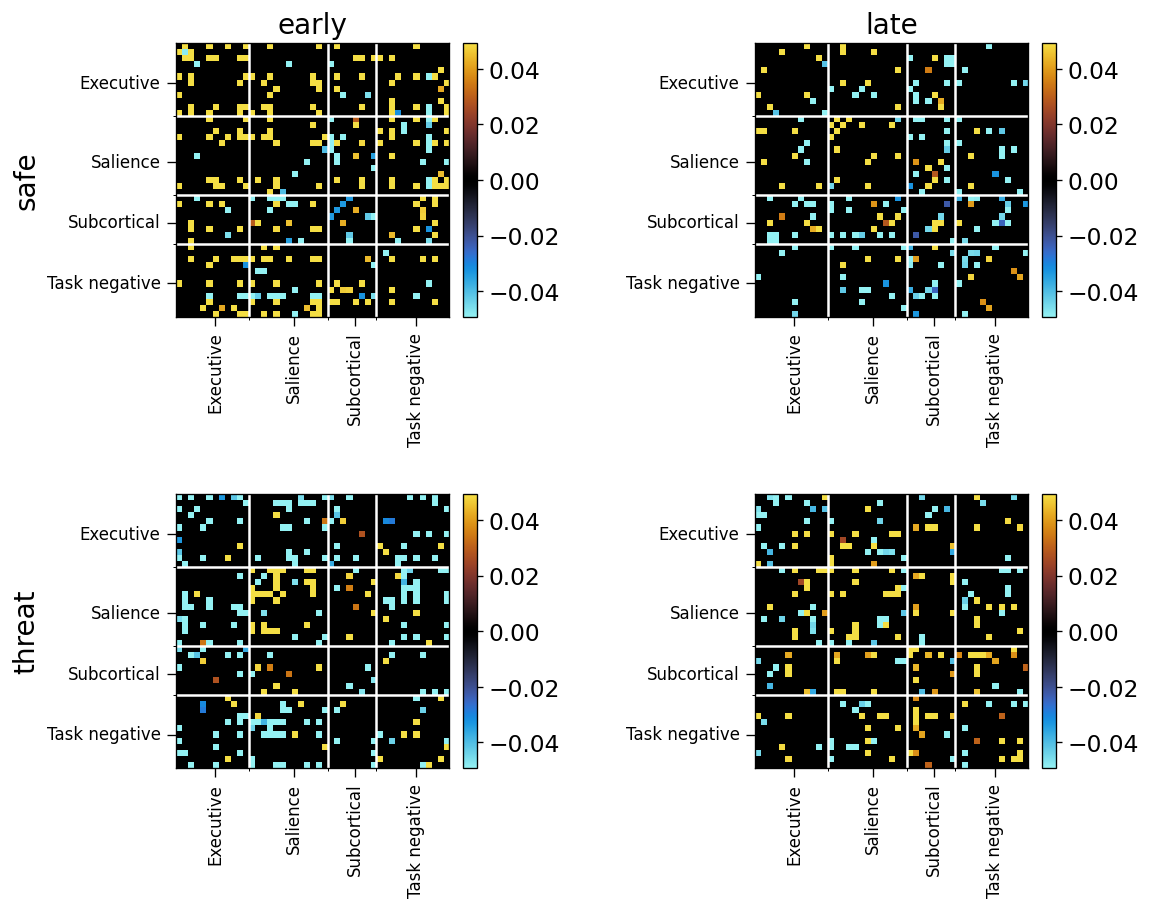

In [6]:
isc_utils.plot_isfcs(args, observed_isfcs, significant_rois)

## statistical testing

In [7]:
stats_results = isc_utils.get_comparison_stats(args, corrs, paradigm='max')

diff_isfcs, diff_pvals = isc_utils.get_diff_isfcs(args, stats_results, significant_rois, threshold_mats=True)

6it [00:13,  2.21s/it]


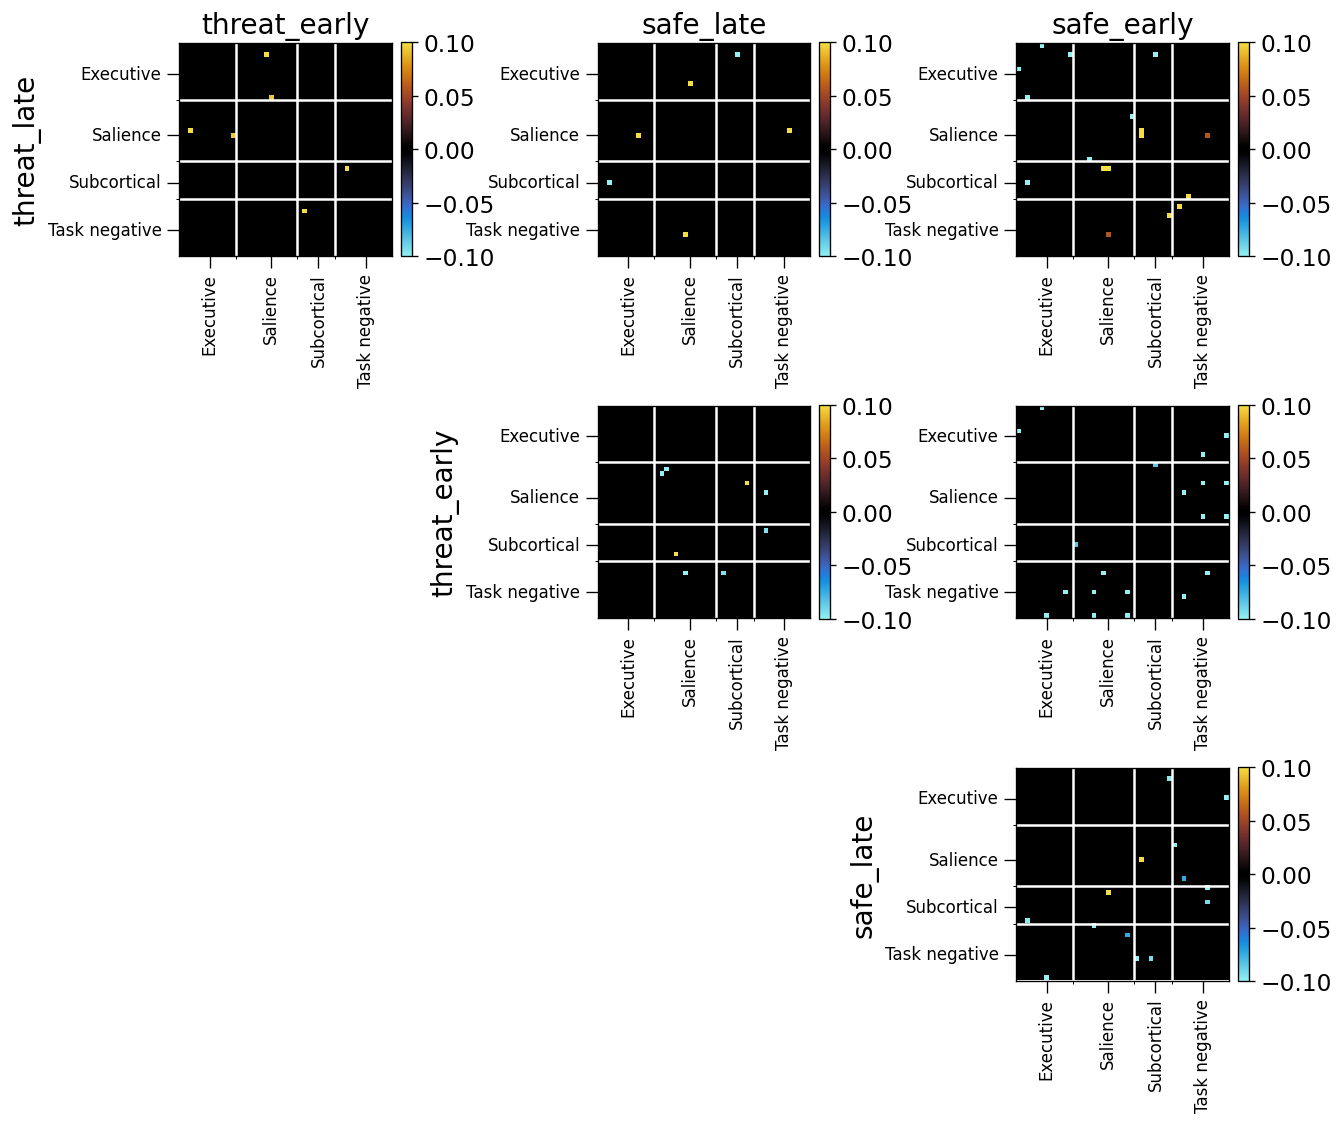

In [8]:
isc_utils.plot_max_isfc_comparisons(args, corrs, diff_isfcs)